<a href="https://colab.research.google.com/github/Shark7EnzoCamargo/TF-Imagenes/blob/main/TF_YOLOv8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TRABAJO FINAL - PROCESAMIENTO DE IMÁGENES**

## Alumno: Camargo Ramírez, Enzo Fabricio (U202010122)

### LINKS DE DESCARGA:
Video 1 -> https://drive.google.com/file/d/1bELm7YV3UFeWAzqKJhc7Y9N2i1z-8VOZ/view?usp=drive_link (75 MB)

Video 2 -> https://drive.google.com/file/d/1CCg57Q8fzEmc5z5SXfv7TGZCxfXBPS83/view?usp=drive_link (205 MB - **Recomendado**)

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
# Ubicacion del video en el drive - Cambio de nombre
!cp "/content/drive/MyDrive//TF/Video2-Imagenes.mp4" Video-TF.mp4

In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/Video-TF.mp4"

In [ ]:
#INSTALANDO Ultralytics YOLOv8

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.212 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 27.3/78.2 GB disk)


In [ ]:
# INSTALANDO BYTE TRACK

# Cambiamos el directorio actual a un valor de variable HOME
%cd {HOME}

# Clonamos el repositorio desde un enlace en Github
!git clone https://github.com/ifzhang/ByteTrack.git

# Cambiamos el directorio actual a uno recien clonado
%cd {HOME}/ByteTrack

#Reemplazamos el archivo requirements.txt para cambiar la version de la biblioteca onnx
!sed -i 's/onnx==1.0.1/onnx==1.9.0/g' requirements.txt

# Instalamos las dependencias listadas en el archivo requirements.txt de forma silenciosa (-q)
!pip3 install -q -r requirements.txt

# Ejecutamos el script setup.py de forma silenciosa (-q) para instalar el paquete
!python3 setup.py -q develop

# Instalamos el paquete cython_bbox de forma silenciosa (-q)
!pip install -q cython_bbox

# Instalamos el paquete onemetric de forma silenciosa (-q)
!pip install -q onemetric

# Instalamos los paquetes loguru, lap y thop de forma silenciosa (-q)
!pip install -q loguru lap thop

# Importamos la fucion clear_output de la libreria IPython.display para limpiar la salida actal de la celda
from IPython import display
display.clear_output()

# Agregamos la ruta del directorio ByteTrack al sistema de busqueda de Python para que los modulos sean importables
import sys
sys.path.append(f"{HOME}/ByteTrack")

# Importamos el modulo yolox y mostramos su version
import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [ ]:
# Importamos las clases BYTETracker y Strack desde el modulo yolox.tracker.byte_tracker
from yolox.tracker.byte_tracker import BYTETracker, STrack

# Importamos la funcion box_iou_batch desde el modulo onemetric.cv.utils.io
from onemetric.cv.utils.iou import box_iou_batch

# Importamos el decorados dataclass desde el modulo dataclasses
from dataclasses import dataclass

# Definimos una clase llamada BYTETracker utilizando el decorador dataclass
@dataclass(frozen=True)
class BYTETrackerArgs:
  # Definimos y asignamos valores predeterminados a varias propiedades (atributos) de la clase
  track_thresh: float = 0.25
  track_buffer: int = 30
  match_thresh: float = 0.8
  aspect_ratio_thresh: float = 3.0
  min_box_area: float = 1.0
  mot20: bool = False

In [ ]:
#INSTALANDO ROBOFLOW SUPERVISION
# Analisis de imagenes y videos
!pip install supervision==0.1.0

from IPython import display
display.clear_output()

import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [ ]:
# Importamos la clase List desde el modulo typing
from typing import List

# Importamos el modulo numpy
import numpy as np

# Definimos una funcion que toma como argumento un objeto de la clase Detections
# devolvemos un array numpy que contiene informacion sobre las detecciones
def detections2boxes(detections: Detections) -> np.ndarray:
  # La funcion np.hstack concatena horizontalmente las matrices proporcionadas
  # Se concatenan las coordenadas xyxy de las detecciones
  return np.hstack((
      detections.xyxy,
      detections.confidence[:, np.newaxis]
  ))

# Definimos una funcion que toma como argumento una lista de objetos de la clase Strack
# y devolvemos un array numpy que contiene coordenadas de las cajas del objeto Strack
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
  # Se crea un array numpy utilizando una comprension de listas
  # Cada elemento de la lista tracks se convierte en su atributo tlbr (top left bottom right)
  return np.array([
      track.tlbr
      for track
      in tracks
  ], dtype=float)

# Definimos una funcion que toma como argumentos un objeto de la clase Detections
# y una lista de objetos de la clase Strack, devuelve una lista de IDs de seguimiento
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
  # Verificamos si no hay coordenadas xyxy en las detecciones o si la lista de tracks esta vacia
  # Si es asi, devuelve un arrayvacio
  if not np.any(detections.xyxy) or len(tracks) == 0:
    return np.empty((0,))

  # Convertimos los objetos STrack en arrays numpy de coordenadas de cajas (tlbr)
  tracks_boxes = tracks2boxes(tracks=tracks)

  # Calculamos la interseccion sobre union (IoU) entre las cajas de deteccion y las cajas de seguimiento
  iou = box_iou_batch(tracks_boxes, detections.xyxy)

  # Para cada deteccion, encontramos el indice de seguimiento con el IoU maximo
  track2detection = np.argmax(iou, axis=1)

  # Creamos una lista para almacenar los IDs de seguimiento correspondientes a las detecciones
  tracker_ids = [None] * len(detections)

  # Asignamos los IDs de seguimiento correspondientes a las detecciones basados en los calculos de IoU
  for tracker_index, detection_index in enumerate(track2detection):
    if iou[tracker_index, detection_index] != 0:
      tracker_ids[detection_index] = tracks[tracker_index].track_id

  # Devolvemos la lista de IDs de seguimiento correspondientes a las detecciones
  return tracker_ids

In [ ]:
# Creamos el modelo
MODEL = "yolov8n.pt"

In [ ]:
# Cargamos el modelo
from ultralytics import YOLO
model = YOLO(MODEL)
model.fuse()

YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


In [ ]:
# Se asigna que detecte personas, el ID de una persona en ultralytics es 0
CLASS_NAMES_DICT = model.model.names
CLASS_ID = [0]


0: 384x640 (no detections), 226.9ms
Speed: 14.1ms preprocess, 226.9ms inference, 9.2ms postprocess per image at shape (1, 3, 384, 640)


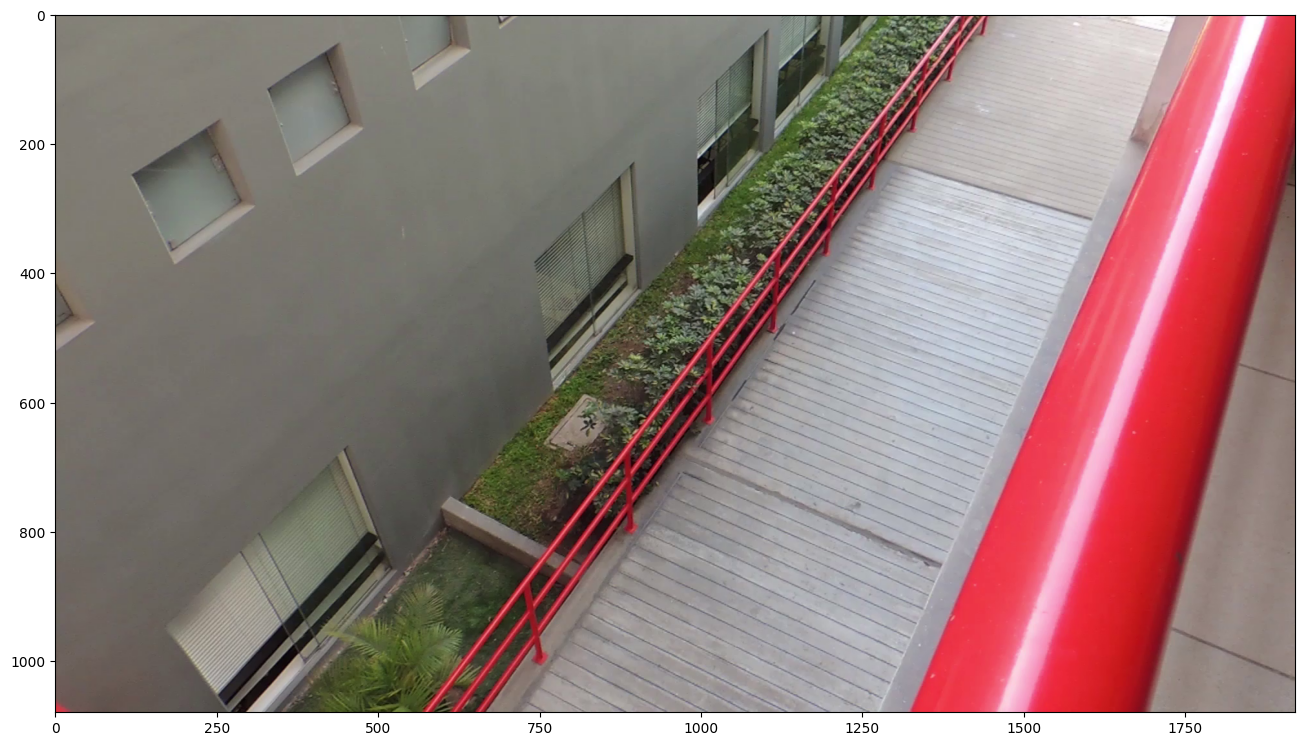

In [ ]:
# Creamos un generador de fotogramas de video con la ruta del video de origen
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

# Creamos una instancia de la clase BoxAnnotator para agregar anotaciones a las cajas
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=2, text_thickness=1, text_scale=0.5)

# Adquirimos el primer fotograma de vieo utilizando un iterador
iterator = iter(generator)
frame = next(iterator)

# Realizamos una prediccion del modelo en un solo fotograma y convertimos los resultados en objetos de Deteccion
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)

# Formateamos etiquetas personalizadas para las detecciones
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]

# Anotamos y mostramos el fotograma con las cajas y etiquetas utilizando la instancia de BoxAnnotator
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

# Mostramos el fotograma en el cuaderno utilizando la funcion show_frame_in_notebook de tamaño (16, 16)
%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

In [ ]:
# Definimos las coordenadas del punto de inicio de una linea en el video utilizando la clase Point
LINE_START = Point(200, 250)

# Definimos las coordenadas del punto de finalizacion de una linea en el video utilizando la clase Point
LINE_END = Point(650-50, 250)

#Defile la ruta del video de destino utilizando la variable HOME para la ubicacion del usuario
TARGET_VIDEO_PATH = f"{HOME}/Video2-Resultado.mp4"

In [ ]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1920, height=1080, fps=29, total_frames=4995)

In [ ]:
# Importamos la funcion tqdm para mostrar una barra de progreso en el cuaderno
from tqdm.notebook import tqdm

# Creamos una instancia de BYTETracker utilizando los argmentos definidos anteriormentes
byte_tracker = BYTETracker(BYTETrackerArgs())

# Creamos una instancia de VideoInfo utilizando la ruta del video de origen
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# Creamos un generador de fotogramas de video utilizando la funcion_get_video_frames_generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

# Creamos una instancia LineCounter utilizando los puntos de inicio y finalizacion de la linea
line_counter = LineCounter(start=LINE_START, end=LINE_END)

# Creamos una instancia de BoxAnnotator para agregar anotaciones a las cajas
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=2, text_thickness=1, text_scale=0.5)

# Creamos una instancia de LineCounterAnnotator para agregar anotaciones al contador de lineas
line_annotator = LineCounterAnnotator(thickness=2, text_thickness=1, text_scale=0.5)


# Inicializamos listas para almacenar datos de entrada, salida y tiempo
entrar = []
salir = []
tiempo = []
i = 0

# Abrimos el archivo de video de destino utilizando VideoSink y la instancia de VideoInfo
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
  # Iteramos sobre los fotogramas del video utilizando tqdm para mostrar la barra de progreso
  for frame in tqdm(generator, total=video_info.total_frames):
    # Realizamos una prediccion del modelo en el fotograma y convertimos los resultados en objetos Detections
    results = model(frame)
    detections = Detections(
        xyxy=results[0].boxes.xyxy.cpu().numpy(),
        confidence=results[0].boxes.conf.cpu().numpy(),
        class_id=results[0].boxes.cls.cpu().numpy().astype(int)
    )

    # Filtramos las detecciones con clases no deseadas
    mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
    detections.filter(mask=mask, inplace=True)

    # Realizamos el seguimiento de las detecciones utilizando BYTETracker
    tracks = byte_tracker.update(
        output_results=detections2boxes(detections=detections),
        img_info=frame.shape,
        img_size=frame.shape
    )

    # Realizamos la correspondencia entre las detecciones y los seguimientos
    tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
    detections.tracker_id = np.array(tracker_id)

    # Filtramos las detecciones que no tienen seguimiento asignado
    mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
    detections.filter(mask=mask, inplace=True)

    # Formateamos etiquetas personalizadas para las detecciones
    labels = [
        f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
        for _, confidence, class_id, tracker_id
        in detections
    ]

    # Actualizamos el contador de lineas
    line_counter.update(detections=detections)

    # Anotamos el fotograma con cajas y etiquetas
    frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

    # Anotamos el contador de lineas en el fotograma
    line_annotator.annotate(frame=frame, line_counter=line_counter)

    # Escribimos el fotograma anotado en el archivo de video de destino
    sink.write_frame(frame)

    # Agregamos los valores del contador de entrada y salida a las listas
    entrar.append(line_counter.in_count)
    salir.append(line_counter.out_count)

    # Incrementamos el contador de tiempo
    i += 1
    tiempo.append(i)

display.clear_output()